![課題_スクリーンショット](../img/課題.png)

## モデリングB(施策の評価)
### 提案施策
#### 1. バーゲン施策の戦略的拡充
    相関分析および状態空間モデルの結果から、バーゲン実施日は売上と強い正の関係を持ち、売上増加に大きく寄与していることが示唆された。このことから、バーゲン施策は本店舗における有効な売上向上手段であると考えられる。したがって、バーゲンを単発的・一律的に実施するのではなく、曜日や季節性を考慮した戦略的な実施が有効であると判断される。具体的には、曜日別分析において売上が低水準となりやすい月曜日や木曜日に限定した短期的なバーゲンを実施することで、来店動機を創出し、売上の底上げを図ることが可能である。また、年周期成分の分析結果より、春から初夏にかけて売上が増加する傾向が確認されていることから、この時期に合わせてバーゲンの規模や頻度を拡大することで、季節需要をより効果的に取り込むことが期待される。

#### 2. 天候・休日を考慮した来店促進施策
    探索的データ分析の結果から、休日であるにもかかわらず売上が必ずしも増加していないこと、また降雨日において売上が低下する傾向が示唆された。このことから、本店舗は自動車来店よりも徒歩による来店客が多く、天候の影響を受けやすい立地条件である可能性が考えられる。そのため、雨天時や祝日においては、来店意欲の低下を補う施策としてオンライン施策や事前告知型のキャンペーンを強化することが有効である。具体的には、雨天限定クーポンの配布や、祝日前からの事前セール告知を行うことで、来店の心理的ハードルを下げ、売上の安定化を図ることができると考えられる。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from prophet import Prophet

import jpholiday

import warnings
warnings.filterwarnings('ignore')

/Users/yutotakagi/Develop/ass-supply-chain-management/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('../data/apparel_clean.csv')

df['ds'] = pd.to_datetime(df['ds'])
display(df.head(3))
display(df.tail(3))

,ds,Weather,Bargain,y,Closed,Holiday
0,1990-01-05,0.0,0.0,58507.0,0,0
1,1990-01-06,0.0,0.0,49088.0,0,0
2,1990-01-07,0.0,0.0,50066.0,0,0


,ds,Weather,Bargain,y,Closed,Holiday
1454,1993-12-29,0.0,0.0,94771.0,0,0
1455,1993-12-30,0.0,0.0,108693.0,0,0
1456,1993-12-31,0.0,0.0,111898.0,0,0


## 評価期間のプレーンパターンの生成

1. 施策により変更できない変数(天気や祝日)を定義する
2. 休業日やバーゲン実施日などを定義し、プレーンデータ(説明変数)を生成する
2. 具体的には、テスト期間（1993年以降）の全ての日付について「Bargain=0, Holiday=0, Closed=0」と仮定し、これをプロフェットモデルへ入力することで、「施策非実施時」の売上予測推移を算出する。
3. 実施施策効果を加味した予測（実測値 or 施策フル実施パターン）と、上記プレーンパターンとの差分を見ることで、施策による上積み効果や改善余地を定量評価できる。
 
 以下では、そのために必要となる評価期間データの「施策非実施」状態生成と、プロフェットによる再予測手順を実装していく。


### 1. 施策により変更できない変数の定義

In [3]:
future_dates = pd.date_range(start='1994-01-01', end='1994-12-31', freq='D')
df_1994 = pd.DataFrame({'ds': future_dates})

df_1994['Weather'] = np.random.choice(df['Weather'].dropna(), size=len(df_1994), replace=True)
df_1994['Bargain'] = 0.0
df_1994['y'] = np.nan
df_1994['Closed'] = 0
df_1994['Holiday'] = df_1994['ds'].apply(lambda x: 1 if jpholiday.is_holiday(x) else 0)

display(df_1994.head(3))
display(df_1994.tail(3))


,ds,Weather,Bargain,y,Closed,Holiday
0,1994-01-01,0.0,0.0,NaN,0,1
1,1994-01-02,1.0,0.0,NaN,0,0
2,1994-01-03,1.0,0.0,NaN,0,0


,ds,Weather,Bargain,y,Closed,Holiday
362,1994-12-29,0.0,0.0,NaN,0,0
363,1994-12-30,1.0,0.0,NaN,0,0
364,1994-12-31,0.0,0.0,NaN,0,0


### 2. プレーンパターンを作成する。
休日は`jpholiday`で生成し、天気, バーゲン実施, 休業日は過去のデータと同一の分布になるように生成する。従って、施策を実施していない状態を擬似的に生成する。

In [4]:
df_1994_plain = df_1994.copy()

for col in ['Bargain', 'Closed']:
    df_1994_plain[col] = np.random.choice(df[col].dropna(), size=len(df_1994), replace=True)

display(df_1994_plain.head(10))

,ds,Weather,Bargain,y,Closed,Holiday
0,1994-01-01,0.0,0.0,NaN,0,1
1,1994-01-02,1.0,1.0,NaN,1,0
2,1994-01-03,1.0,0.0,NaN,0,0
3,1994-01-04,0.0,0.0,NaN,0,0
4,1994-01-05,0.0,0.0,NaN,1,0
5,1994-01-06,1.0,1.0,NaN,0,0
6,1994-01-07,1.0,1.0,NaN,0,0
7,1994-01-08,0.0,1.0,NaN,0,0
8,1994-01-09,1.0,0.0,NaN,0,0
9,1994-01-10,0.0,0.0,NaN,0,0


### 3. 施策を反映させたデータを作成する

In [5]:
df_1994_policy = df_1994.copy()
df_1994_policy["Bargain"] = df_1994_policy["ds"].dt.weekday.isin([0, 3]).astype(float)  # 月曜（0）・木曜（3）をバーゲン日

# --- 木曜日の営業日設定を柔軟化 ---
# 木曜日(ds.dt.weekday==3)については、隔週営業とする: 偶数週は営業(Closed=0)、奇数週は休業(Closed=1)
# 週番号は「ds.dt.isocalendar().week」で取得
# ただし、短時間営業等の設定例として、Closed=0.5で表現することも可能（ここでは両方例示）
df_1994_policy["Closed"] = 0

# 曜日・週番号抽出
thursday_mask = df_1994_policy["ds"].dt.weekday == 3
weeks_for_thursday = df_1994_policy.loc[thursday_mask, "ds"].dt.isocalendar().week

# 木曜日で週番号に応じて Closed を更新（ブールインデックスを利用）
thursday_and_week1 = thursday_mask & (df_1994_policy["ds"].dt.isocalendar().week == 1)
df_1994_policy.loc[thursday_and_week1, "Closed"] = 1
thursday_and_week2or3 = thursday_mask & (df_1994_policy["ds"].dt.isocalendar().week.isin([2,3]))
df_1994_policy.loc[thursday_and_week2or3, "Closed"] = 0.5

# 春～初夏（例：4～6月）はバーゲン強化
spring_mask = df_1994_policy["ds"].dt.month.isin([4, 5, 6])
df_1994_policy.loc[spring_mask, "Bargain"] = 1

df_1994_policy.loc[df_1994_policy["Holiday"] == 1, "Bargain"] = 1

display(df_1994_policy.head(10))


,ds,Weather,Bargain,y,Closed,Holiday
0,1994-01-01,0.0,1.0,NaN,0.0,1
1,1994-01-02,1.0,0.0,NaN,0.0,0
2,1994-01-03,1.0,1.0,NaN,0.0,0
3,1994-01-04,0.0,0.0,NaN,0.0,0
4,1994-01-05,0.0,0.0,NaN,0.0,0
5,1994-01-06,1.0,1.0,NaN,1.0,0
6,1994-01-07,1.0,0.0,NaN,0.0,0
7,1994-01-08,0.0,0.0,NaN,0.0,0
8,1994-01-09,1.0,0.0,NaN,0.0,0
9,1994-01-10,0.0,1.0,NaN,0.0,0


In [6]:
df_plain = pd.concat([df, df_1994_plain])
df_policy = pd.concat([df, df_1994_policy])

display(df_1994_plain.tail(3))
display(df_1994_policy.tail(3))

,ds,Weather,Bargain,y,Closed,Holiday
362,1994-12-29,0.0,0.0,NaN,0,0
363,1994-12-30,1.0,0.0,NaN,0,0
364,1994-12-31,0.0,1.0,NaN,1,0


,ds,Weather,Bargain,y,Closed,Holiday
362,1994-12-29,0.0,1.0,NaN,0.0,0
363,1994-12-30,1.0,0.0,NaN,0.0,0
364,1994-12-31,0.0,0.0,NaN,0.0,0


### 4. プレーンデータにおける予測

In [7]:
# 祝日
h_holiday = df_plain.loc[df_plain['Holiday'] == 1, ['ds']].copy()
h_holiday['holiday'] = 'holiday'
h_holiday['lower_window'] = 0
h_holiday['upper_window'] = 0

# 天気
h_weather = df_plain.loc[df_plain['Weather'] == 1, ['ds']].copy()
h_weather['holiday'] = 'weather'
h_weather['lower_window'] = 0
h_weather['upper_window'] = 0

# バーゲン
h_bargain = df_plain.loc[df_plain['Bargain'] == 1, ['ds']].copy()
h_bargain['holiday'] = 'bargain'
h_bargain['lower_window'] = 0
h_bargain['upper_window'] = 0


# 休業日
h_closed = df_plain.loc[df_plain['Closed'] == 1, ['ds']].copy()
h_closed['holiday'] = 'closed'
h_closed['lower_window'] = 0
h_closed['upper_window'] = 0

holidays = pd.concat([h_holiday, h_weather, h_bargain, h_closed], ignore_index=True)
holidays = holidays[['holiday', 'ds', 'lower_window', 'upper_window']].sort_values(by='ds').reset_index(drop=True)
holidays.head(20)

,holiday,ds,lower_window,upper_window
0,bargain,1990-01-10,0,0
1,weather,1990-01-10,0,0
2,bargain,1990-01-11,0,0
3,bargain,1990-01-12,0,0
4,bargain,1990-01-13,0,0
5,weather,1990-01-13,0,0
6,holiday,1990-01-15,0,0
7,weather,1990-01-16,0,0
8,closed,1990-01-18,0,0
9,weather,1990-01-19,0,0


03:13:07 - cmdstanpy - INFO - Chain [1] start processing
03:13:07 - cmdstanpy - INFO - Chain [1] done processing


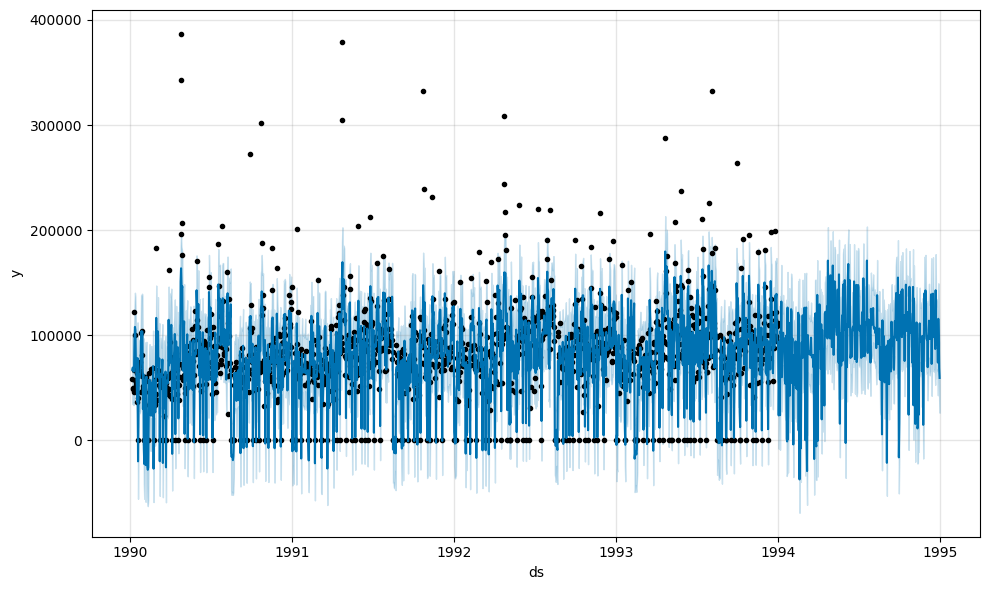

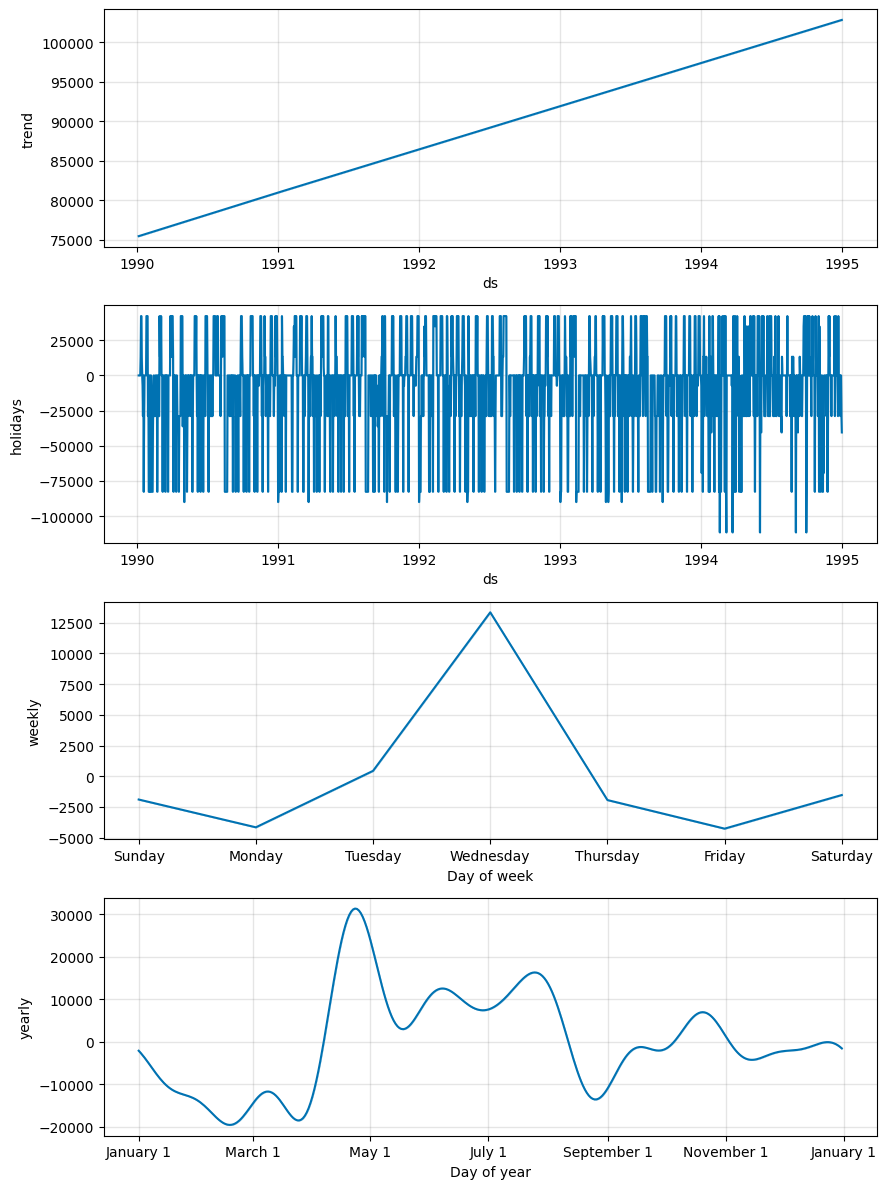

In [8]:
m = Prophet(weekly_seasonality = True, yearly_seasonality = True, holidays= holidays)
m.fit(df_plain)

#予測する日付を生成
future_plain = m.make_future_dataframe(periods=0)
forecast_plain = m.predict(future_plain)
fig1 = m.plot(forecast_plain)
fig2 = m.plot_components(forecast_plain)

In [9]:
now = datetime.now().strftime('%Y%m%d_%H%M%S')
with open(f'../models/model_b_1_{now}.pkl', 'wb') as f:
    pickle.dump(m, f)

### 5. 施策実施モデルによる予測

In [10]:
# 祝日
h_holiday = df_policy.loc[df_policy['Holiday'] == 1, ['ds']].copy()
h_holiday['holiday'] = 'holiday'
h_holiday['lower_window'] = 0
h_holiday['upper_window'] = 0

# 天気
h_weather = df_policy.loc[df_policy['Weather'] == 1, ['ds']].copy()
h_weather['holiday'] = 'weather'
h_weather['lower_window'] = 0
h_weather['upper_window'] = 0

# バーゲン
h_bargain = df_policy.loc[df_policy['Bargain'] == 1, ['ds']].copy()
h_bargain['holiday'] = 'bargain'
h_bargain['lower_window'] = 0
h_bargain['upper_window'] = 0


# 休業日
h_closed = df_policy.loc[df_policy['Closed'] == 1, ['ds']].copy()
h_closed['holiday'] = 'closed'
h_closed['lower_window'] = 0
h_closed['upper_window'] = 0

holidays = pd.concat([h_holiday, h_weather, h_bargain, h_closed], ignore_index=True)
holidays = holidays[['holiday', 'ds', 'lower_window', 'upper_window']].sort_values(by='ds').reset_index(drop=True)
holidays.head(20)

,holiday,ds,lower_window,upper_window
0,bargain,1990-01-10,0,0
1,weather,1990-01-10,0,0
2,bargain,1990-01-11,0,0
3,bargain,1990-01-12,0,0
4,bargain,1990-01-13,0,0
5,weather,1990-01-13,0,0
6,holiday,1990-01-15,0,0
7,weather,1990-01-16,0,0
8,closed,1990-01-18,0,0
9,weather,1990-01-19,0,0


03:13:08 - cmdstanpy - INFO - Chain [1] start processing
03:13:08 - cmdstanpy - INFO - Chain [1] done processing


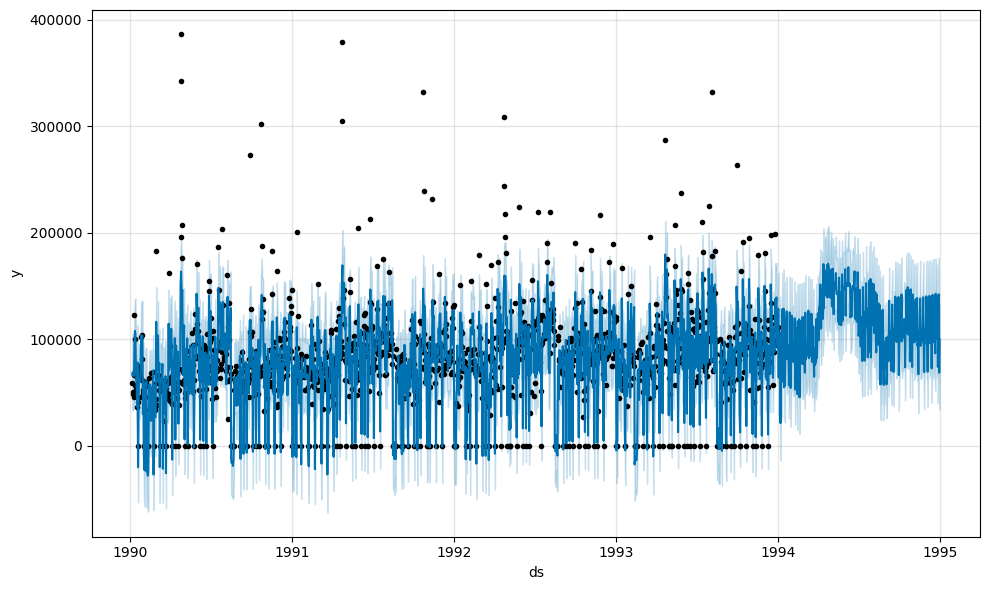

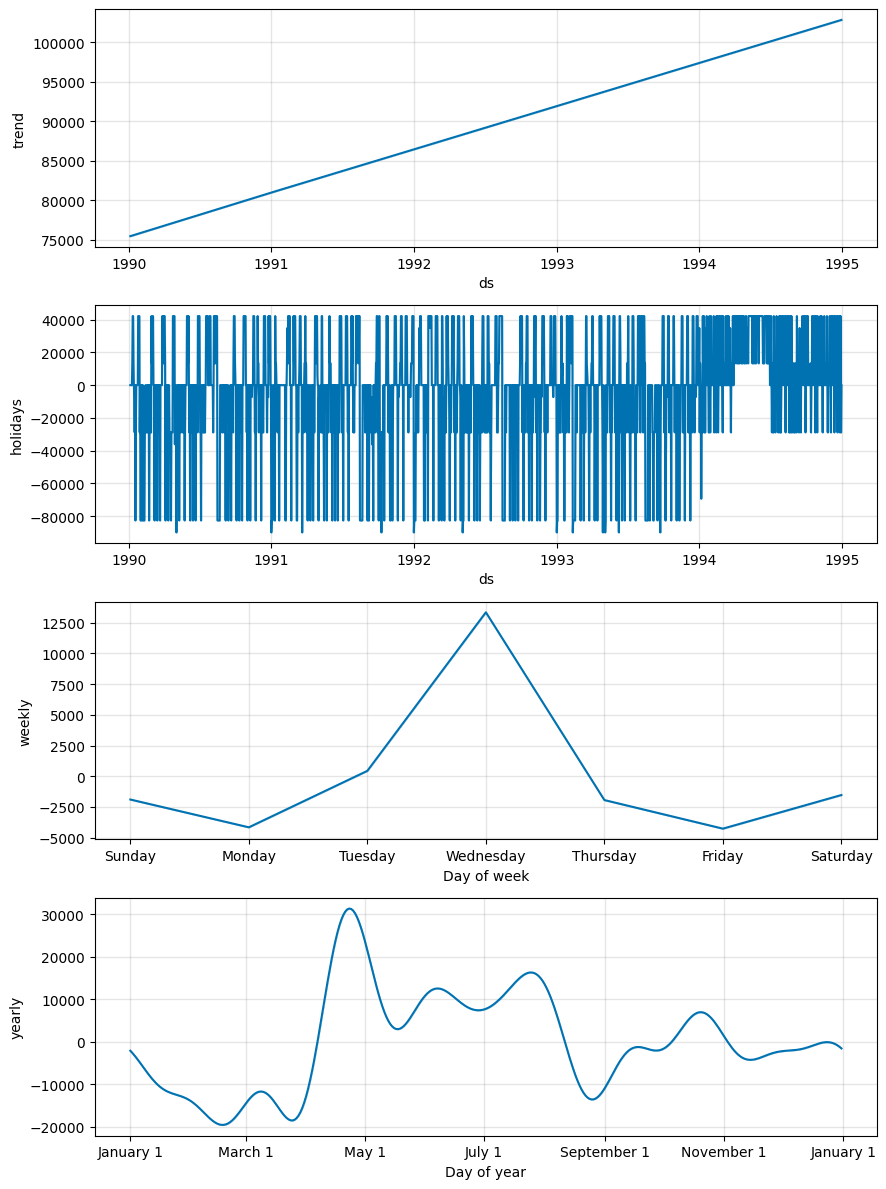

In [11]:
m = Prophet(weekly_seasonality = True, yearly_seasonality = True, holidays= holidays)
m.fit(df_policy)

#予測する日付を生成
future_policy = m.make_future_dataframe(periods=0)
forecast_policy = m.predict(future_policy)
fig1 = m.plot(forecast_policy)
fig2 = m.plot_components(forecast_policy)

In [12]:
now = datetime.now().strftime('%Y%m%d_%H%M%S')
with open(f'../models/model_b_2_{now}.pkl', 'wb') as f:
    pickle.dump(m, f)

In [13]:
compare_df = pd.merge(
    forecast_plain[['ds', 'yhat']],
    forecast_policy[['ds', 'yhat']],
    on='ds',
    suffixes=('_plain', '_policy')
)
display(compare_df.head(10))

,ds,yhat_plain,yhat_policy
0,1990-01-05,67036.104953,67036.104953
1,1990-01-06,69167.556377,69167.556377
2,1990-01-07,68183.427410,68183.427410
3,1990-01-08,65298.711632,65298.711632
4,1990-01-09,69271.961870,69271.961870
5,1990-01-10,94858.396655,94858.396655
6,1990-01-11,107884.457951,107884.457951
7,1990-01-12,104998.980508,104998.980508
8,1990-01-13,78327.898768,78327.898768
9,1990-01-14,64175.720567,64175.720567


1994年のyhat_plainの平均: 92462.02
1994年のyhat_policyの平均: 112516.52


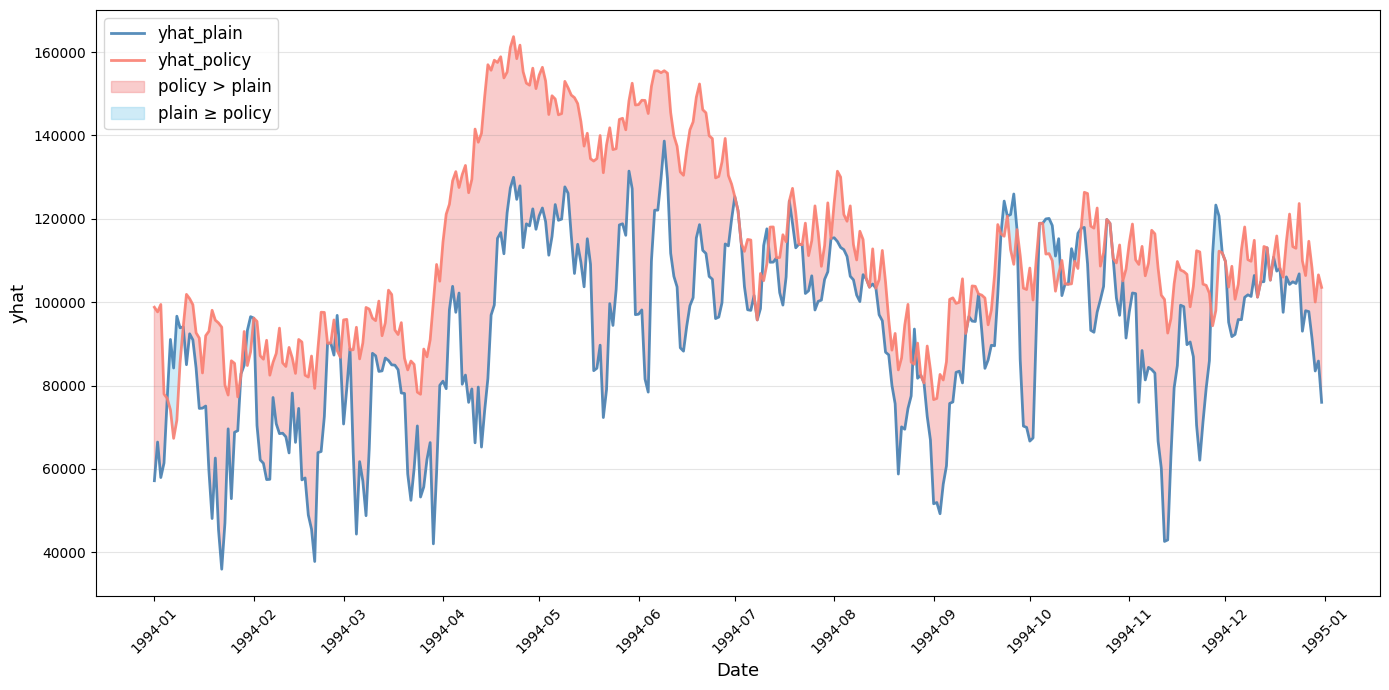

In [14]:
compare_df_1994 = compare_df[
    (compare_df['ds'] >= '1994-01-01') & (compare_df['ds'] <= '1994-12-31')
]


mean_plain = compare_df_1994['yhat_plain'].mean()
mean_policy = compare_df_1994['yhat_policy'].mean()

print(f"1994年のyhat_plainの平均: {mean_plain:.2f}")
print(f"1994年のyhat_policyの平均: {mean_policy:.2f}")

plt.figure(figsize=(14,7))
window = 5

ds = pd.to_datetime(compare_df_1994['ds'])
yhat_plain_smooth = compare_df_1994['yhat_plain'].rolling(window, center=True, min_periods=1).mean()
yhat_policy_smooth = compare_df_1994['yhat_policy'].rolling(window, center=True, min_periods=1).mean()

plt.plot(ds, yhat_plain_smooth, label='yhat_plain', color='steelblue', linewidth=2, alpha=0.9)
plt.plot(ds, yhat_policy_smooth, label='yhat_policy', color='salmon', linewidth=2, alpha=0.9)

# yhat_policyがyhat_plainを上回る領域を赤、下回る領域を青で塗り分け
diff = yhat_policy_smooth - yhat_plain_smooth
plt.fill_between(
    ds, 
    yhat_plain_smooth, 
    yhat_policy_smooth, 
    where=(diff>0), 
    color='lightcoral', 
    alpha=0.4, 
    interpolate=True, 
    label='policy > plain'
)
plt.fill_between(
    ds, 
    yhat_plain_smooth, 
    yhat_policy_smooth, 
    where=(diff<=0), 
    color='skyblue', 
    alpha=0.4, 
    interpolate=True, 
    label='plain ≥ policy'
)

plt.xlabel('Date', fontsize=13)
plt.ylabel('yhat', fontsize=13)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tick_params(axis='x', labelrotation=45)
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='white')
plt.grid(axis='y', color='gray', alpha=0.2)
plt.tight_layout()
plt.show()

